The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


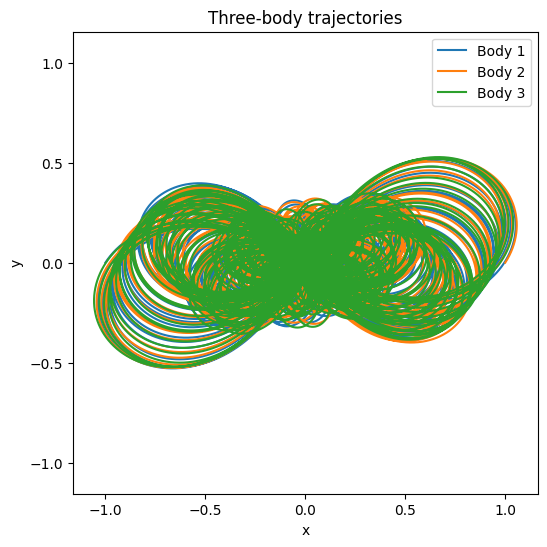

<class 'scipy.integrate._ivp.ivp.OdeResult'>
(3, 218192) <class 'numpy.ndarray'>


In [37]:
from data_creation import get_trajectories
%load_ext autoreload
%autoreload 2

sol = get_trajectories()

x,y,vx,vy,t = sol

print(x.shape, type(y))
# print((x1.shape), type(y1))

2.386150302944891e-22
2.9979157911778733e-10


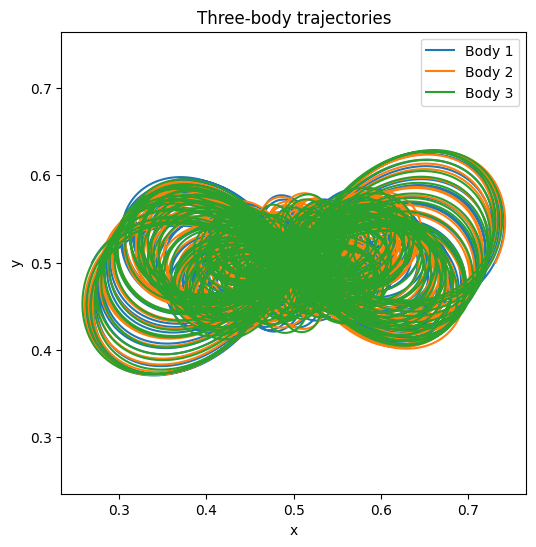

In [ ]:
import numpy as np


# Applied sigmoid but does not seem to do much
# We can first try without sigmoid


# custom function
def sigmoid(x):
  return 1 / (1 + np.exp(-x))


# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# # test
x_sig = sigmoid(x)  
y_sig = sigmoid(y)
vx_sig = sigmoid(vx)
vy_sig = sigmoid(vy)


print(min(vx_sig[0]))
print(min(vy_sig[0]))

